| **Chapter**                   | 8:  Spatial dynamics of epidemics                                                      |
| ----------------------------- |----------------------------------------------------------------------------------------|
| **Computational Note**        | 8.x: k-interdiction                                                                    |
| **Package prerequisites**     | [osmnx](https://osmnx.readthedocs.io/en/stable/), [igraph](https://igraph.org/python/) |


# k-interdiction

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as ticker
import itertools
import colorcet as cc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import osmnx
import igraph as ig
import networkx as nx
import random
import warnings
from tqdm import auto as tqdm

SMALL_SIZE = 5
matplotlib.rc("font", size=SMALL_SIZE)
matplotlib.rc("axes", titlesize=SMALL_SIZE)

random.seed(1234)

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}


In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay"

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

matplotlib: 3.5.2
networkx  : 2.8.4
osmnx     : 1.2.0
colorcet  : 3.0.0
numpy     : 1.21.6
geopandas : 0.10.2
tqdm      : 4.64.0
igraph    : 0.9.9
pandas    : 1.4.2



# Setting parameters

In [3]:
location = "Hong Kong SAR"
bbox = (22.307, 22.337, 114.16, 114.20)

# Importing map data

## Importing the connectivity graph

In [4]:
%%time
osmnx.settings.log_console=True

graph = osmnx.graph_from_bbox(*bbox, network_type="drive", simplify=True)

CPU times: user 2.63 s, sys: 73.5 ms, total: 2.7 s
Wall time: 3.12 s


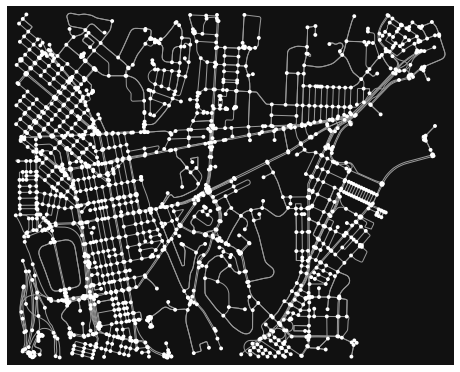

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [5]:
osmnx.plot_graph(graph)

In [6]:
osm_ids = list(graph.nodes)
graph = osmnx.project_graph(graph, to_crs=2326)
gproj = graph.copy()
graph = osmnx.simplification.consolidate_intersections(graph, tolerance=30)
graph = nx.relabel.convert_node_labels_to_integers(graph)
graph.remove_edges_from(nx.selfloop_edges(graph))
edge_keys = list(graph.edges)

osm_id_vals = {k: v for k, v in zip(graph.nodes, osm_ids)}
nx.set_node_attributes(graph, osm_id_vals, "osmid")

i_graph = ig.Graph(directed=True)
i_graph.add_vertices(graph.nodes)
i_graph.add_edges(graph.edges())
i_graph.es["uvk"] = edge_keys
i_graph.es["length"] = list(nx.get_edge_attributes(graph, "length").values())

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:499: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  subcluster_centroid = node_points.loc[wcc].unary_union.centroid
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:500: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "x"] = subcluster_centroid.x
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:501: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  gdf.loc[wcc, "y"] = subcluster_centroid.y
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/osmnx/simplification.py:503: FutureW

In [7]:
nodes, edges = osmnx.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True)

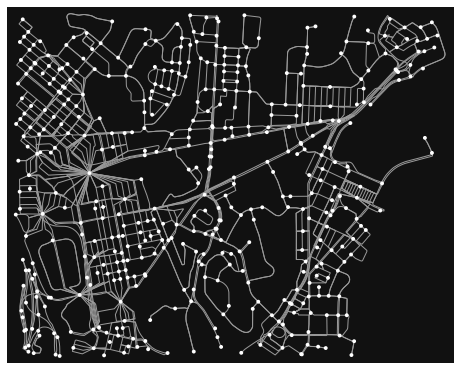

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [8]:
osmnx.plot_graph(graph)

In [9]:
coastline = osmnx.geometries_from_bbox(*bbox, tags={"natural": "coastline"})
# state_boundary = osmnx.geometries_from_bbox(*bbox, tags={"boundary": "administrative", "admin_level": "3"})
coastline.geometry = coastline.geometry.to_crs(2326)

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarnin

<AxesSubplot:>

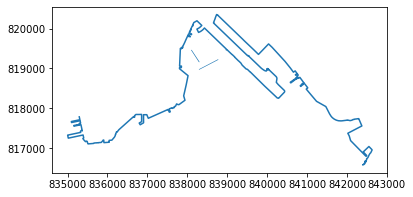

In [10]:
coastline.plot()

In [11]:
nodes, edges = osmnx.graph_to_gdfs(graph, nodes=True, edges=True, node_geometry=True)

In [12]:
edges

osmid  oneway lanes  \
u   v   key                                                           
0   1   0                                   102506130    True     3   
        1                                   102506129    True   NaN   
        2                                   150801672    True     2   
        3                                   101166569    True   NaN   
    396 0           [987256904, 859770922, 436371172]    True     2   
...                                               ...     ...   ...   
458 224 0                                   552424940    True     2   
459 327 0    [98547392, 98532482, 98532459, 66348976]    True     2   
    313 0                      [249573042, 150771679]    True     2   
461 407 0                      [884272389, 442616759]   False     2   
462 40  0                                  1067542362   False   NaN   

                                                         name       highway  \
u   v   key                                                                   
0   1   0                                     彌敦道 Nathan Road       primary   
        1                                   鴉打街 Arthur Street   residential   
        2                             新填地街 Reclamation Street     secondary   
        3                                    廟街 Temple Street   residential   
    396 0              [加士居道 Gascoigne Road, 彌敦道 Nathan Road]  primary_link   
...                                                       ...           ...   
458 224 0                                  世運道 Olympic Avenue     secondary   
459 327 0    [窩打老道 Waterloo Road, 公主道 Princess Margaret Road]         trunk   
    313 0                                  窩打老道 Waterloo Road       primary   
461 407 0                              大環道東 Tai Wan Road East  unclassified   
462 40  0                                                 NaN   residential   

            reversed      length  \
u   v   key                        
0   1   0      False  312.355079   
        1      False  242.277211   
        2      False  279.644426   
        3      False  206.574369   
    396 0      False  313.644478   
...              ...         ...   
458 224 0      False  376.611855   
459 327 0      False  552.558206   
    313 0      False  277.936021   
461 407 0      False  137.144916   
462 40  0       True   82.818873   

                                                      geometry  u_original  \
u   v   key                                                                  
0   1   0    LINESTRING (835585.704 819015.263, 835672.477 ...    33004487   
        1    LINESTRING (835585.704 819015.263, 835629.830 ...  1636768902   
        2    LINESTRING (835585.704 819015.263, 835506.619 ...  1624950144   
        3    LINESTRING (835585.704 819015.263, 835602.958 ...  1636768900   
    396 0    LINESTRING (835585.704 819015.263, 835689.827 ...  1183787457   
...                                                        ...         ...   
458 224 0    LINESTRING (837970.942 821114.290, 837967.686 ...  9457162432   
459 327 0    LINESTRING (836419.597 820505.770, 836418.753 ...  4860301263   
    313 0    LINESTRING (836419.597 820505.770, 836418.753 ...  4860301263   
461 407 0    LINESTRING (837786.317 818683.534, 837795.133 ...  6179056016   
462 40  0    LINESTRING (835510.582 818943.748, 835518.781 ...  9801209287   

             v_original maxspeed bridge  ref tunnel area junction access  
u   v   key                                                               
0   1   0    1172757801      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
        1    1172757982      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
        2    1636768904      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
        3     991295126      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
    396 0    1625210019       50    NaN  NaN    NaN  NaN      NaN    NaN  
...                 ...      ...    ...  ...    ...  ...      ...    ...  
458 224 0   

In [13]:
sourcex, sourcey = 836151.13, 820010.00

In [14]:
source_node = osmnx.nearest_nodes(graph, X=sourcex, Y=sourcey)

In [15]:
source_node

319

In [16]:
infectious_radius = 1
infectious_nodes = i_graph.neighborhood(source_node, order=infectious_radius, mode="out")

In [17]:
len(infectious_nodes)

5

In [18]:
edges

osmid  oneway lanes  \
u   v   key                                                           
0   1   0                                   102506130    True     3   
        1                                   102506129    True   NaN   
        2                                   150801672    True     2   
        3                                   101166569    True   NaN   
    396 0           [987256904, 859770922, 436371172]    True     2   
...                                               ...     ...   ...   
458 224 0                                   552424940    True     2   
459 327 0    [98547392, 98532482, 98532459, 66348976]    True     2   
    313 0                      [249573042, 150771679]    True     2   
461 407 0                      [884272389, 442616759]   False     2   
462 40  0                                  1067542362   False   NaN   

                                                         name       highway  \
u   v   key                                                                   
0   1   0                                     彌敦道 Nathan Road       primary   
        1                                   鴉打街 Arthur Street   residential   
        2                             新填地街 Reclamation Street     secondary   
        3                                    廟街 Temple Street   residential   
    396 0              [加士居道 Gascoigne Road, 彌敦道 Nathan Road]  primary_link   
...                                                       ...           ...   
458 224 0                                  世運道 Olympic Avenue     secondary   
459 327 0    [窩打老道 Waterloo Road, 公主道 Princess Margaret Road]         trunk   
    313 0                                  窩打老道 Waterloo Road       primary   
461 407 0                              大環道東 Tai Wan Road East  unclassified   
462 40  0                                                 NaN   residential   

            reversed      length  \
u   v   key                        
0   1   0      False  312.355079   
        1      False  242.277211   
        2      False  279.644426   
        3      False  206.574369   
    396 0      False  313.644478   
...              ...         ...   
458 224 0      False  376.611855   
459 327 0      False  552.558206   
    313 0      False  277.936021   
461 407 0      False  137.144916   
462 40  0       True   82.818873   

                                                      geometry  u_original  \
u   v   key                                                                  
0   1   0    LINESTRING (835585.704 819015.263, 835672.477 ...    33004487   
        1    LINESTRING (835585.704 819015.263, 835629.830 ...  1636768902   
        2    LINESTRING (835585.704 819015.263, 835506.619 ...  1624950144   
        3    LINESTRING (835585.704 819015.263, 835602.958 ...  1636768900   
    396 0    LINESTRING (835585.704 819015.263, 835689.827 ...  1183787457   
...                                                        ...         ...   
458 224 0    LINESTRING (837970.942 821114.290, 837967.686 ...  9457162432   
459 327 0    LINESTRING (836419.597 820505.770, 836418.753 ...  4860301263   
    313 0    LINESTRING (836419.597 820505.770, 836418.753 ...  4860301263   
461 407 0    LINESTRING (837786.317 818683.534, 837795.133 ...  6179056016   
462 40  0    LINESTRING (835510.582 818943.748, 835518.781 ...  9801209287   

             v_original maxspeed bridge  ref tunnel area junction access  
u   v   key                                                               
0   1   0    1172757801      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
        1    1172757982      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
        2    1636768904      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
        3     991295126      NaN    NaN  NaN    NaN  NaN      NaN    NaN  
    396 0    1625210019       50    NaN  NaN    NaN  NaN      NaN    NaN  
...                 ...      ...    ...  ...    ...  ...      ...    ...  
458 224 0   

In [19]:
nodes = nodes.drop("osmid", axis=1)
nodes.geometry = nodes.geometry.to_crs(2326)
nodes = nodes.reset_index()
nodes["is_infectious"] = False
nodes.loc[infectious_nodes, "is_infectious"] = True

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarnin

(834000.0, 839000.0)

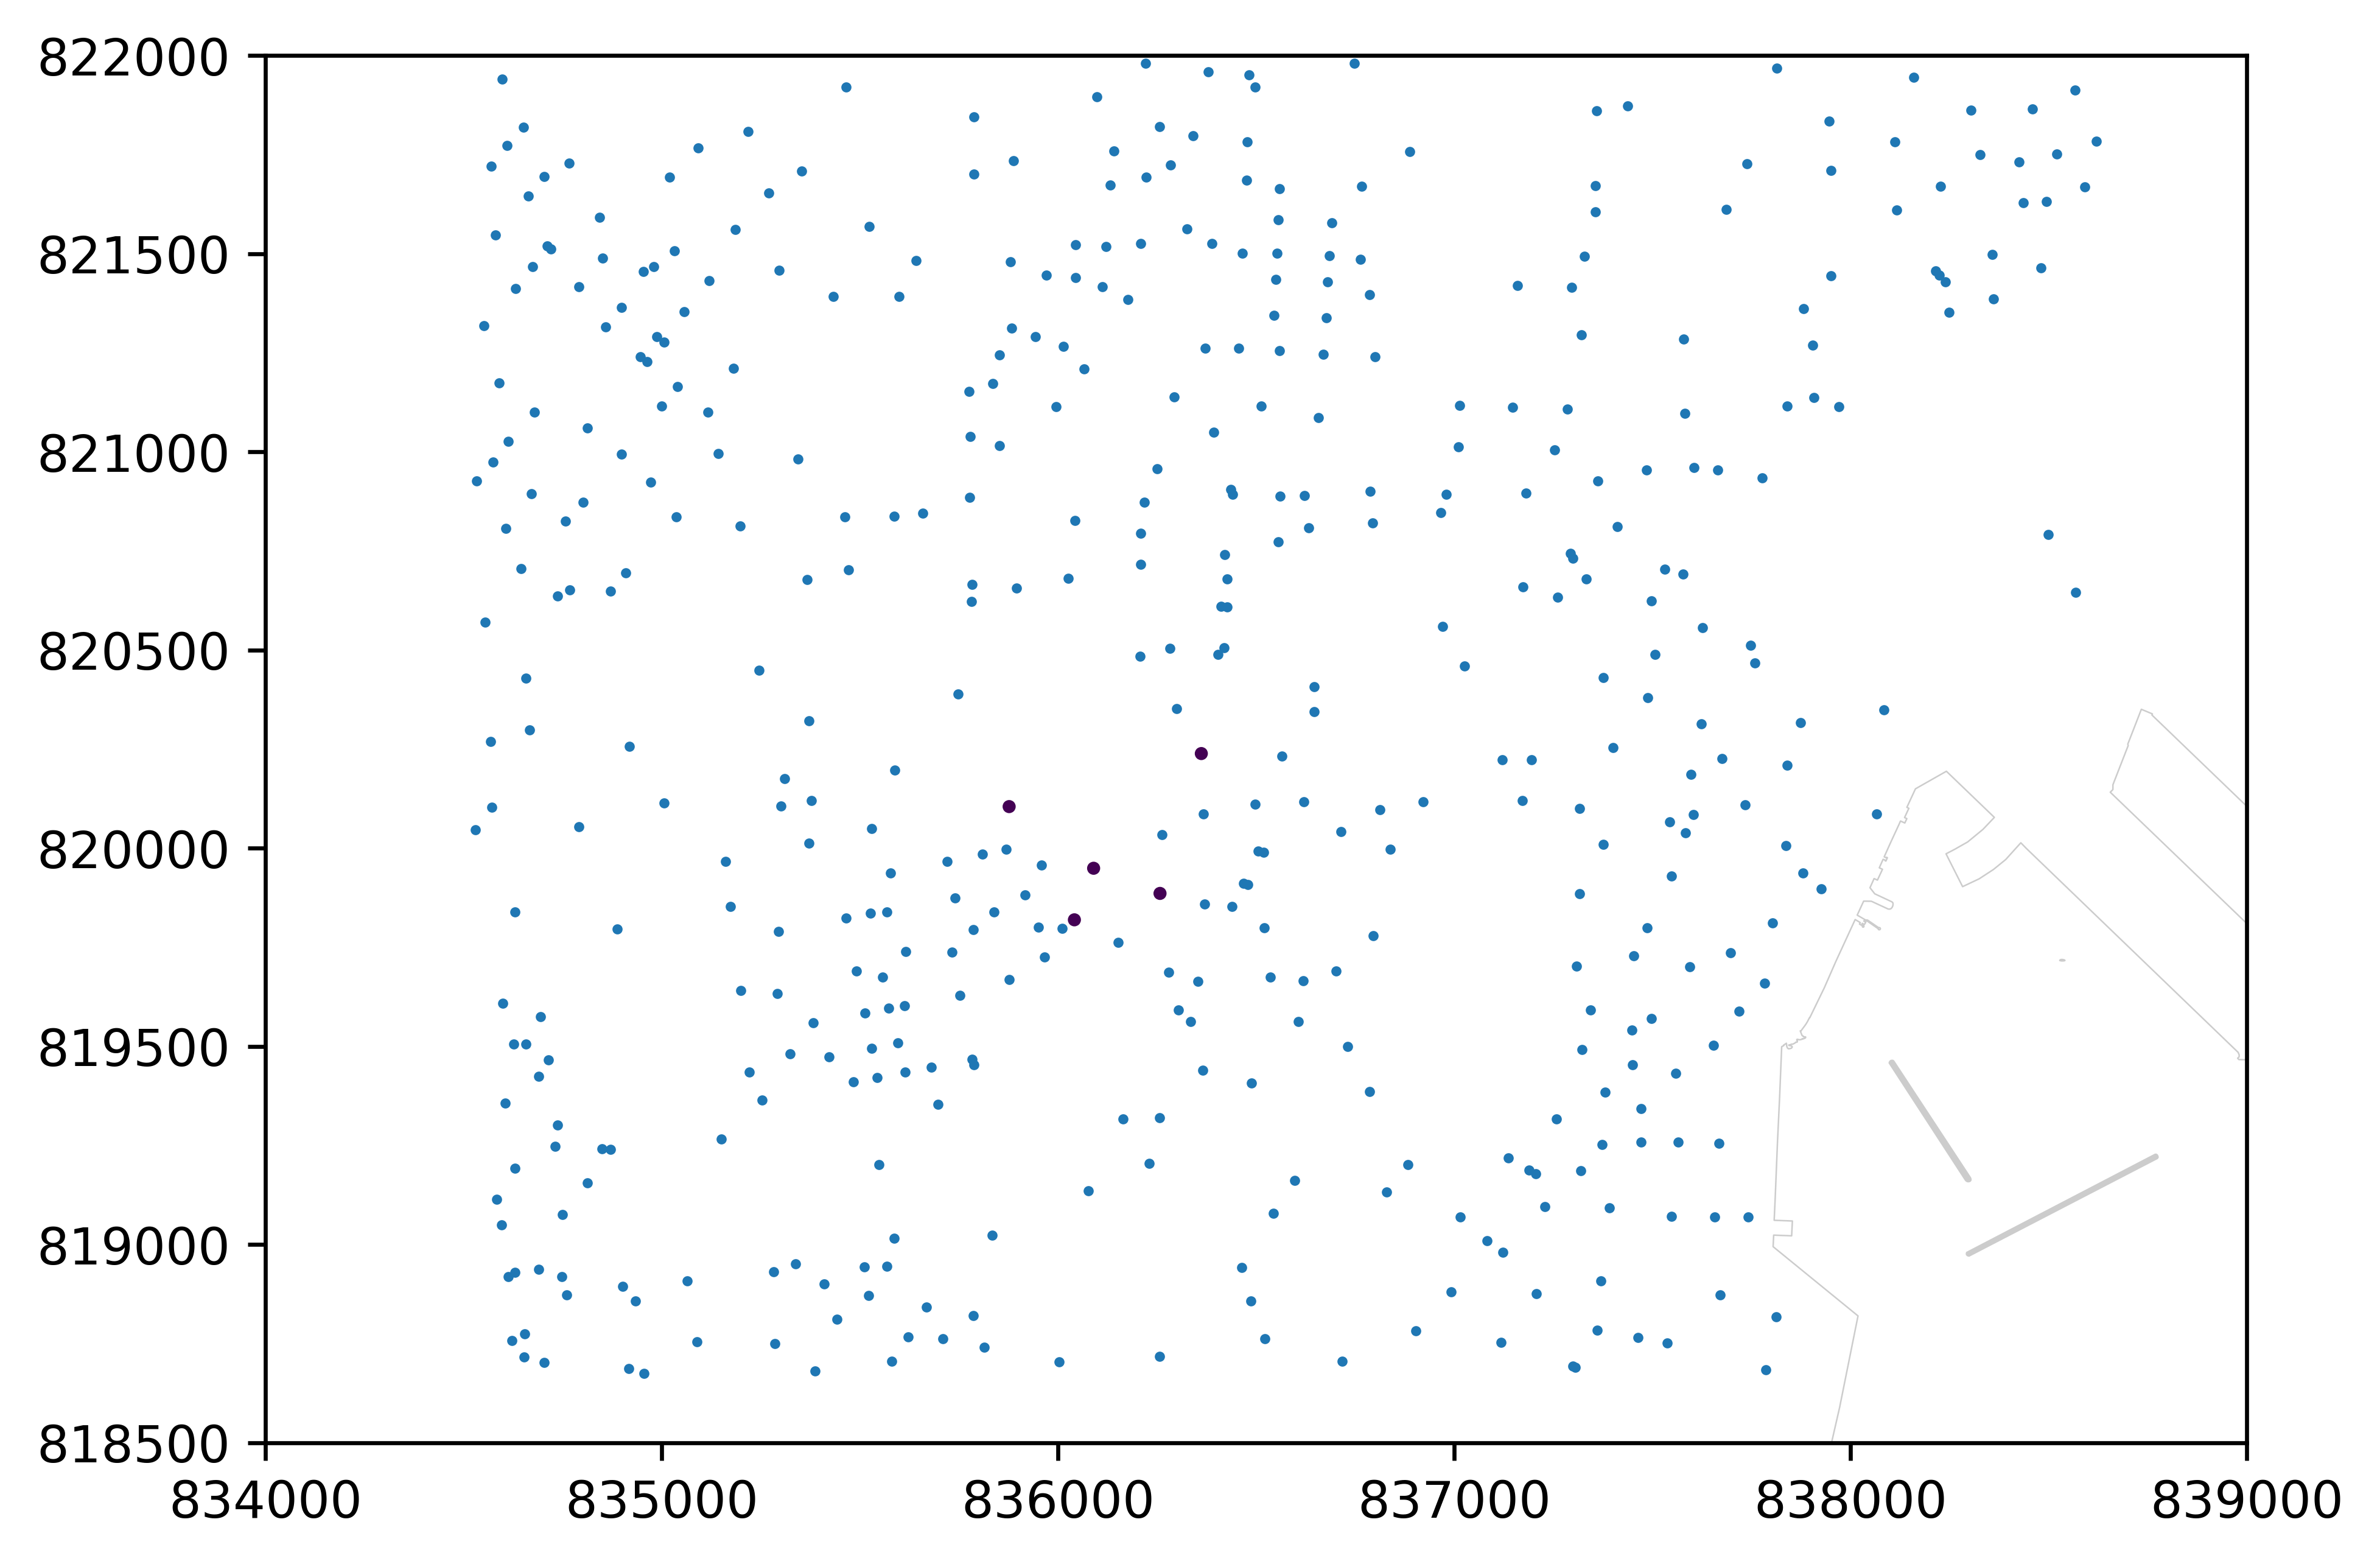

In [20]:
fig = plt.figure(facecolor="w", figsize=(7, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

coastline.plot(ax=ax, color="k", zorder=1, alpha=0.2, lw=0.3)

nodes[nodes.is_infectious == True].plot("is_infectious", ax=ax, c="k", markersize=2.5, zorder=3)
nodes.plot(ax=ax, zorder=2, markersize=1)
ax.set_ylim(818500, 822000)
ax.set_xlim(834000, 839000)

In [21]:
def get_distance(G, source_node, destination_node) -> float:
    return sum(list(map(lambda x: G.es[x]["length"], G.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))

In [22]:
@np.vectorize
def dnin(G, node) -> float:
    """Distance to the nearest infectious node."""
    distances = []

    for infectious_node in infectious_nodes:
        dist = get_distance(G, source_node=node, destination_node=infectious_node)
        if dist > 0:
            distances.append(dist)
        else:
            distances.append(np.nan)

    return np.min(distances)

In [23]:
nodes["dnin"] = list(map(lambda x: float(dnin(i_graph, x)), range(0, len(nodes))))

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_3724/3599818022.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  return sum(list(map(lambda x: G.es[x]["length"], G.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))


In [24]:
nodes

osmid                                     osmid_original              x  \
0        0  [33004487, 1636768902, 1183787459, 1183787457,...  835585.703860   
1        1  [1172757801, 33004488, 1151084822, 1183787466,...  835547.110216   
2        2                                           34971938  835410.067550   
3        3  [332246178, 274243086, 6637957634, 278948068, ...  835149.514451   
4        4                                          332248700  835220.711153   
..     ...                                                ...            ...   
458    458                           [2558033411, 9457162432]  837970.942006   
459    459                           [4860301265, 4860301263]  836419.597274   
460    460                                         9514050834  834955.222798   
461    461                                         6179056016  837786.316930   
462    462                                         9801209287  835510.582197   

                 y  street_count  ref            highway         lon  \
0    819015.263008             0  NaN                NaN         NaN   
1    819201.127232             0  NaN                NaN         NaN   
2    818900.577915             3   6D  motorway_junction  114.168548   
3    819266.566688             0  NaN                NaN         NaN   
4    819435.127403             3  NaN                NaN  114.166710   
..             ...           ...  ...                ...         ...   
458  821114.289890             0  NaN                NaN         NaN   
459  820505.770160             0  NaN                NaN         NaN   
460  818674.877184             3  NaN                NaN  114.164134   
461  818683.534032             3  NaN                NaN  114.191610   
462  818943.748124             3  NaN                NaN  114.169523   

           lat                       geometry  is_infectious         dnin  
0          NaN  POINT (835585.704 819015.263)          False  1236.989129  
1          NaN  POINT (835547.110 819201.127)          False  1030.414760  
2    22.309074  POINT (835410.068 818900.578)          False  1936.599394  
3          NaN  POINT (835149.514 819266.567)          False  1460.265110  
4    22.313901  POINT (835220.711 819435.127)          False  1658.610298  
..         ...                            ...            ...          ...  
458        NaN  POINT (837970.942 821114.290)          False  3036.201715  
459        NaN  POINT (836419.597 820505.770)          False   277.936021  
460  22.307036  POINT (834955.223 818674.877)          False          NaN  
461  22.307114  POINT (837786.317 818683.534)          False  2333.397981  
462  22.309464  POINT (835510.582 818943.748)          False  1644.647735  

[463 rows x 12 columns]

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarnin

(834000.0, 839000.0)

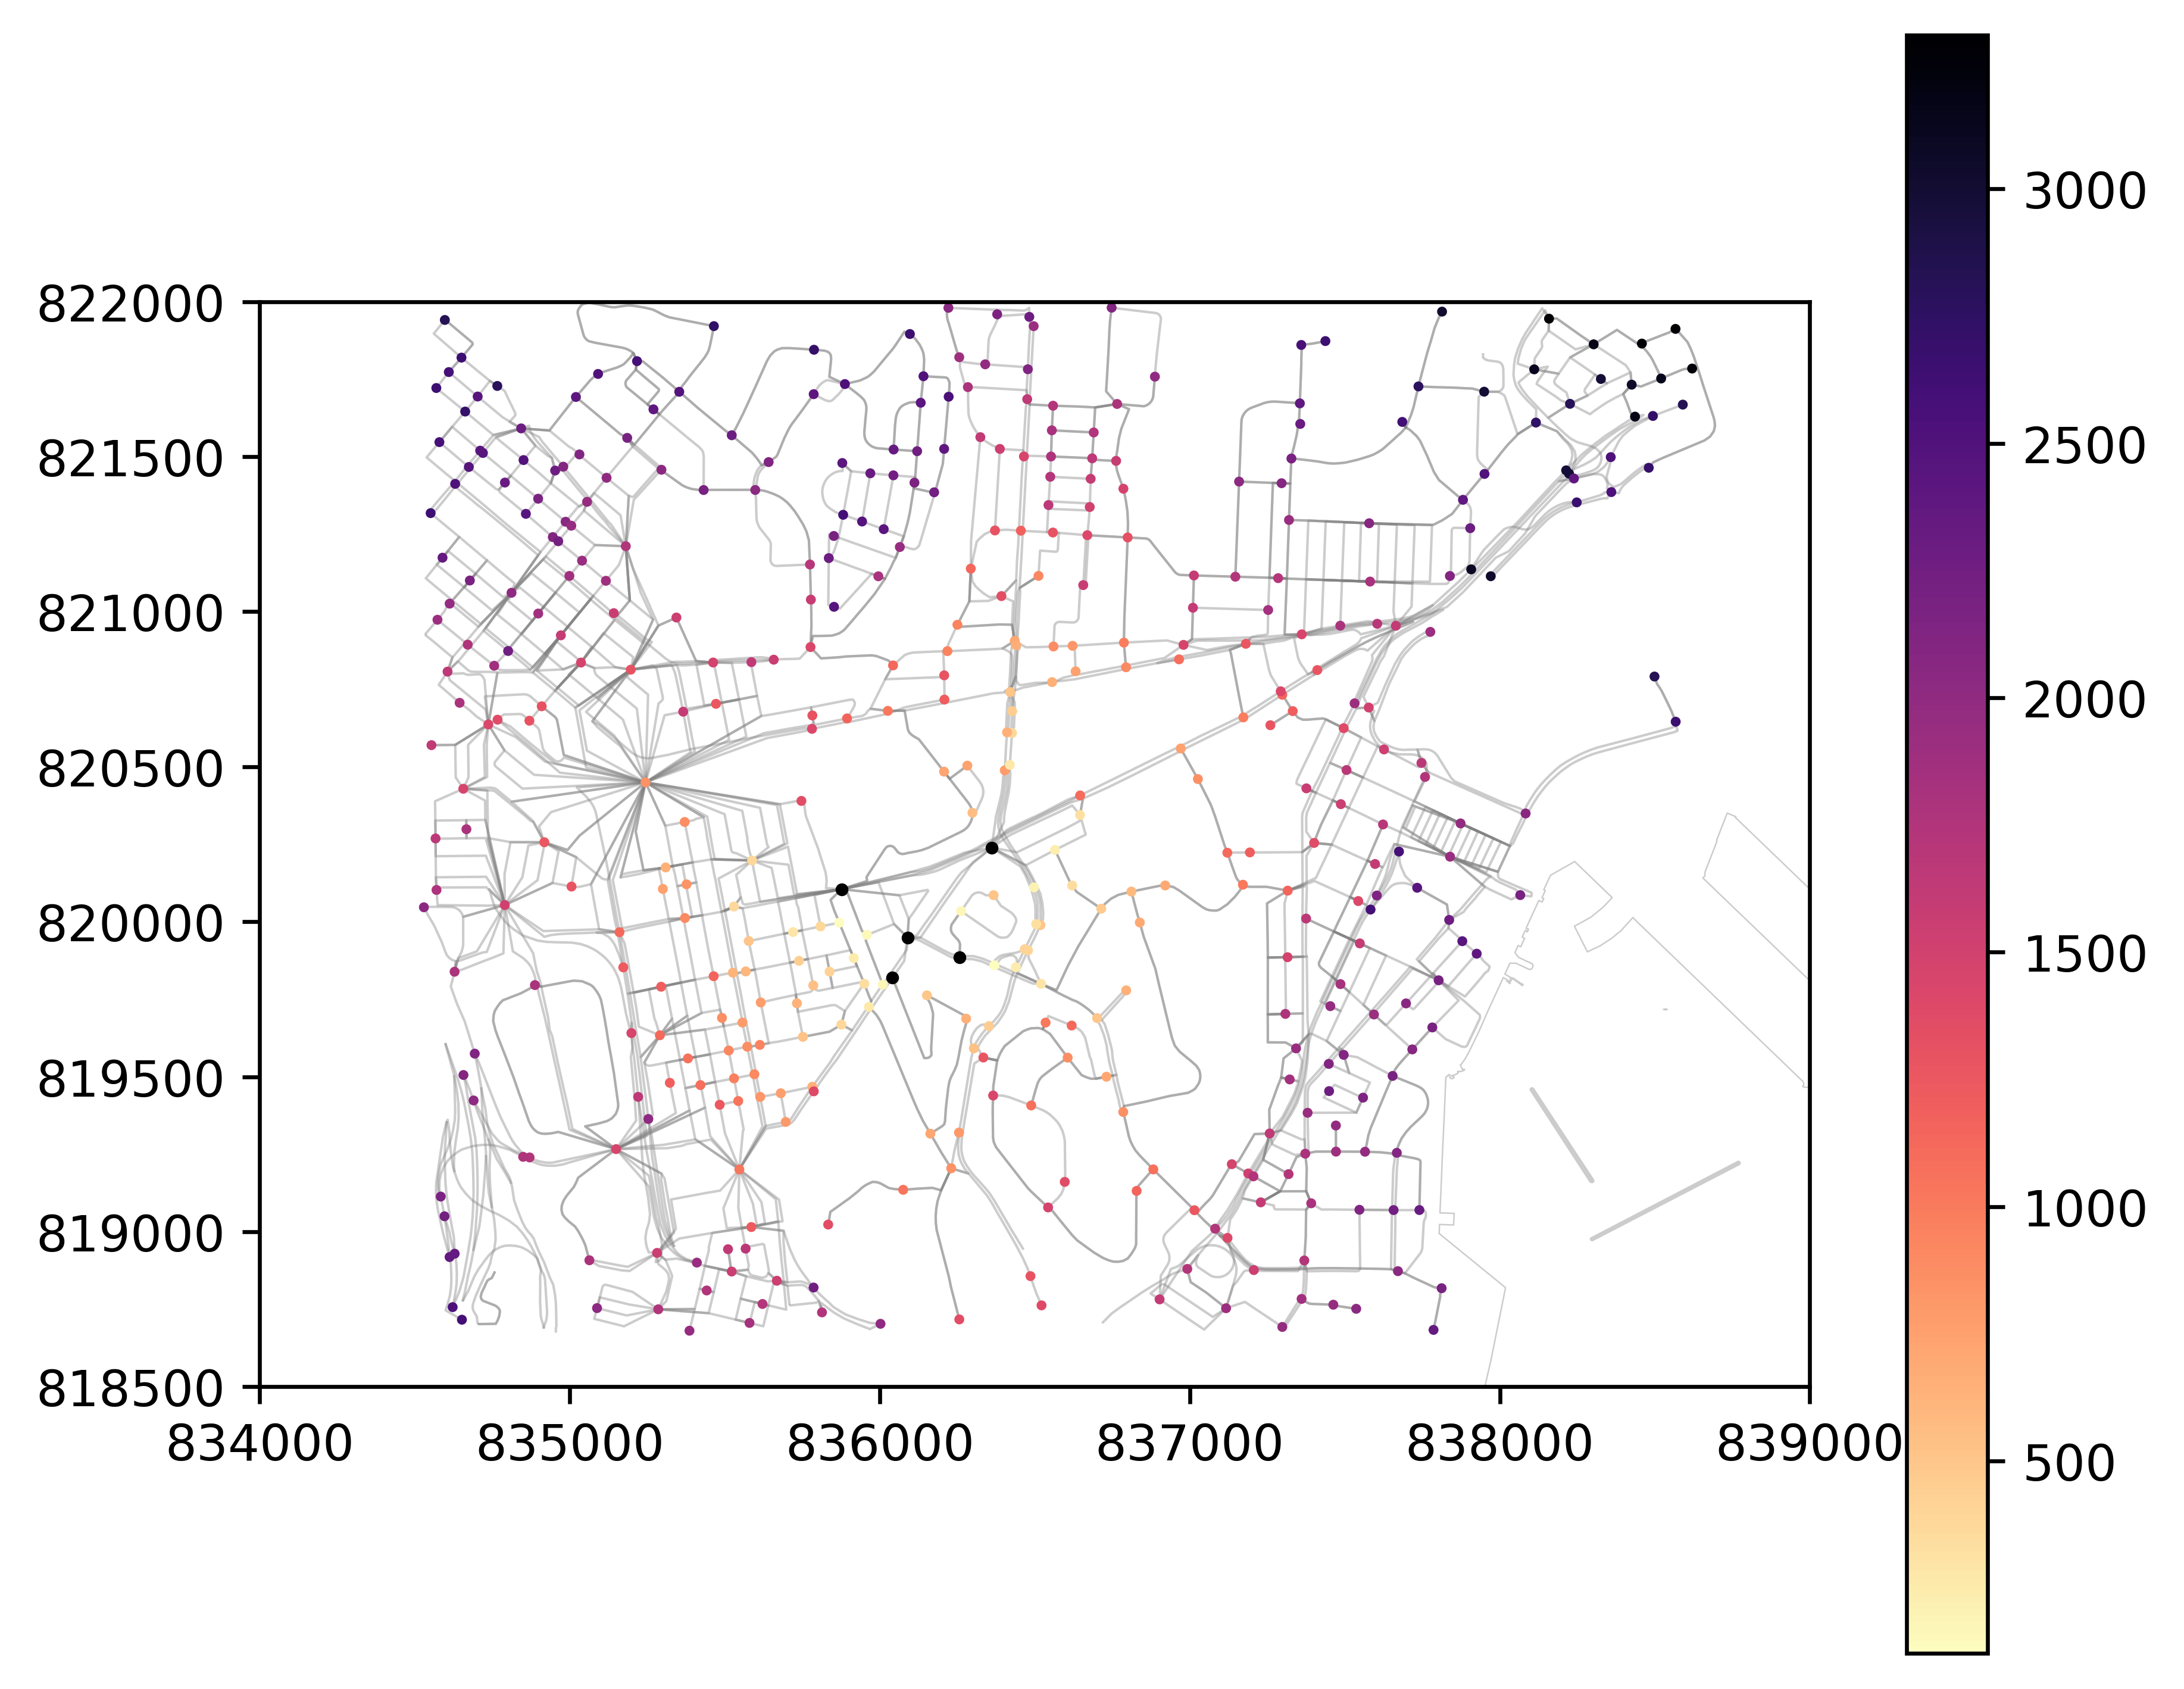

In [25]:
fig = plt.figure(facecolor="w", figsize=(7, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

pedges = edges.copy()
pedges.geometry = pedges.geometry.to_crs(2326)
pedges.plot(ax=ax, lw=0.5, color='gray', zorder=1, alpha=0.4)

nodes[nodes.is_infectious == True].plot(ax=ax, color="k", markersize=2.5, zorder=3)
nodes[nodes.is_infectious == False].plot("dnin", ax=ax, cmap="magma_r", zorder=2, markersize=1, legend=True)
coastline.plot(ax=ax, color="k", zorder=1, alpha=0.2, lw=0.3)

ax.set_ylim(818500, 822000)
ax.set_xlim(834000, 839000)

In [26]:
def network_infectious_efficiency(G, infectious_subgraph):
    uninfected_nodes = G.vcount() - len(infectious_subgraph)

    agg = 0

    for i in range(G.vcount()):
        if i not in infectious_subgraph:
            dist_nin = dnin(G, i)
            if not np.isnan(dist_nin) and dist_nin > 0:
                agg += 1/dist_nin

    return agg

In [27]:
network_infectious_efficiency(i_graph, infectious_nodes)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_3724/3599818022.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  return sum(list(map(lambda x: G.es[x]["length"], G.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))


0.38258470547766144

In [28]:
def delta_efficiency(G):
    base_efficiency = network_infectious_efficiency(G, i_graph.neighborhood(source_node, order=infectious_radius, mode="out"))

    deltas = []

    for edge in tqdm.tqdm(G.es):
        modified_graph = G.copy()
        modified_graph.delete_edges(edge)
        gpeff = network_infectious_efficiency(modified_graph, G.neighborhood(source_node, order=infectious_radius, mode="out"))
        deltas.append((base_efficiency - gpeff)/base_efficiency)

    return deltas

In [29]:
efficiencies = delta_efficiency(i_graph)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_3724/3599818022.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  return sum(list(map(lambda x: G.es[x]["length"], G.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))


  0%|          | 0/1232 [00:00<?, ?it/s]

In [30]:
edges["delta_efficiency"] = efficiencies

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarnin

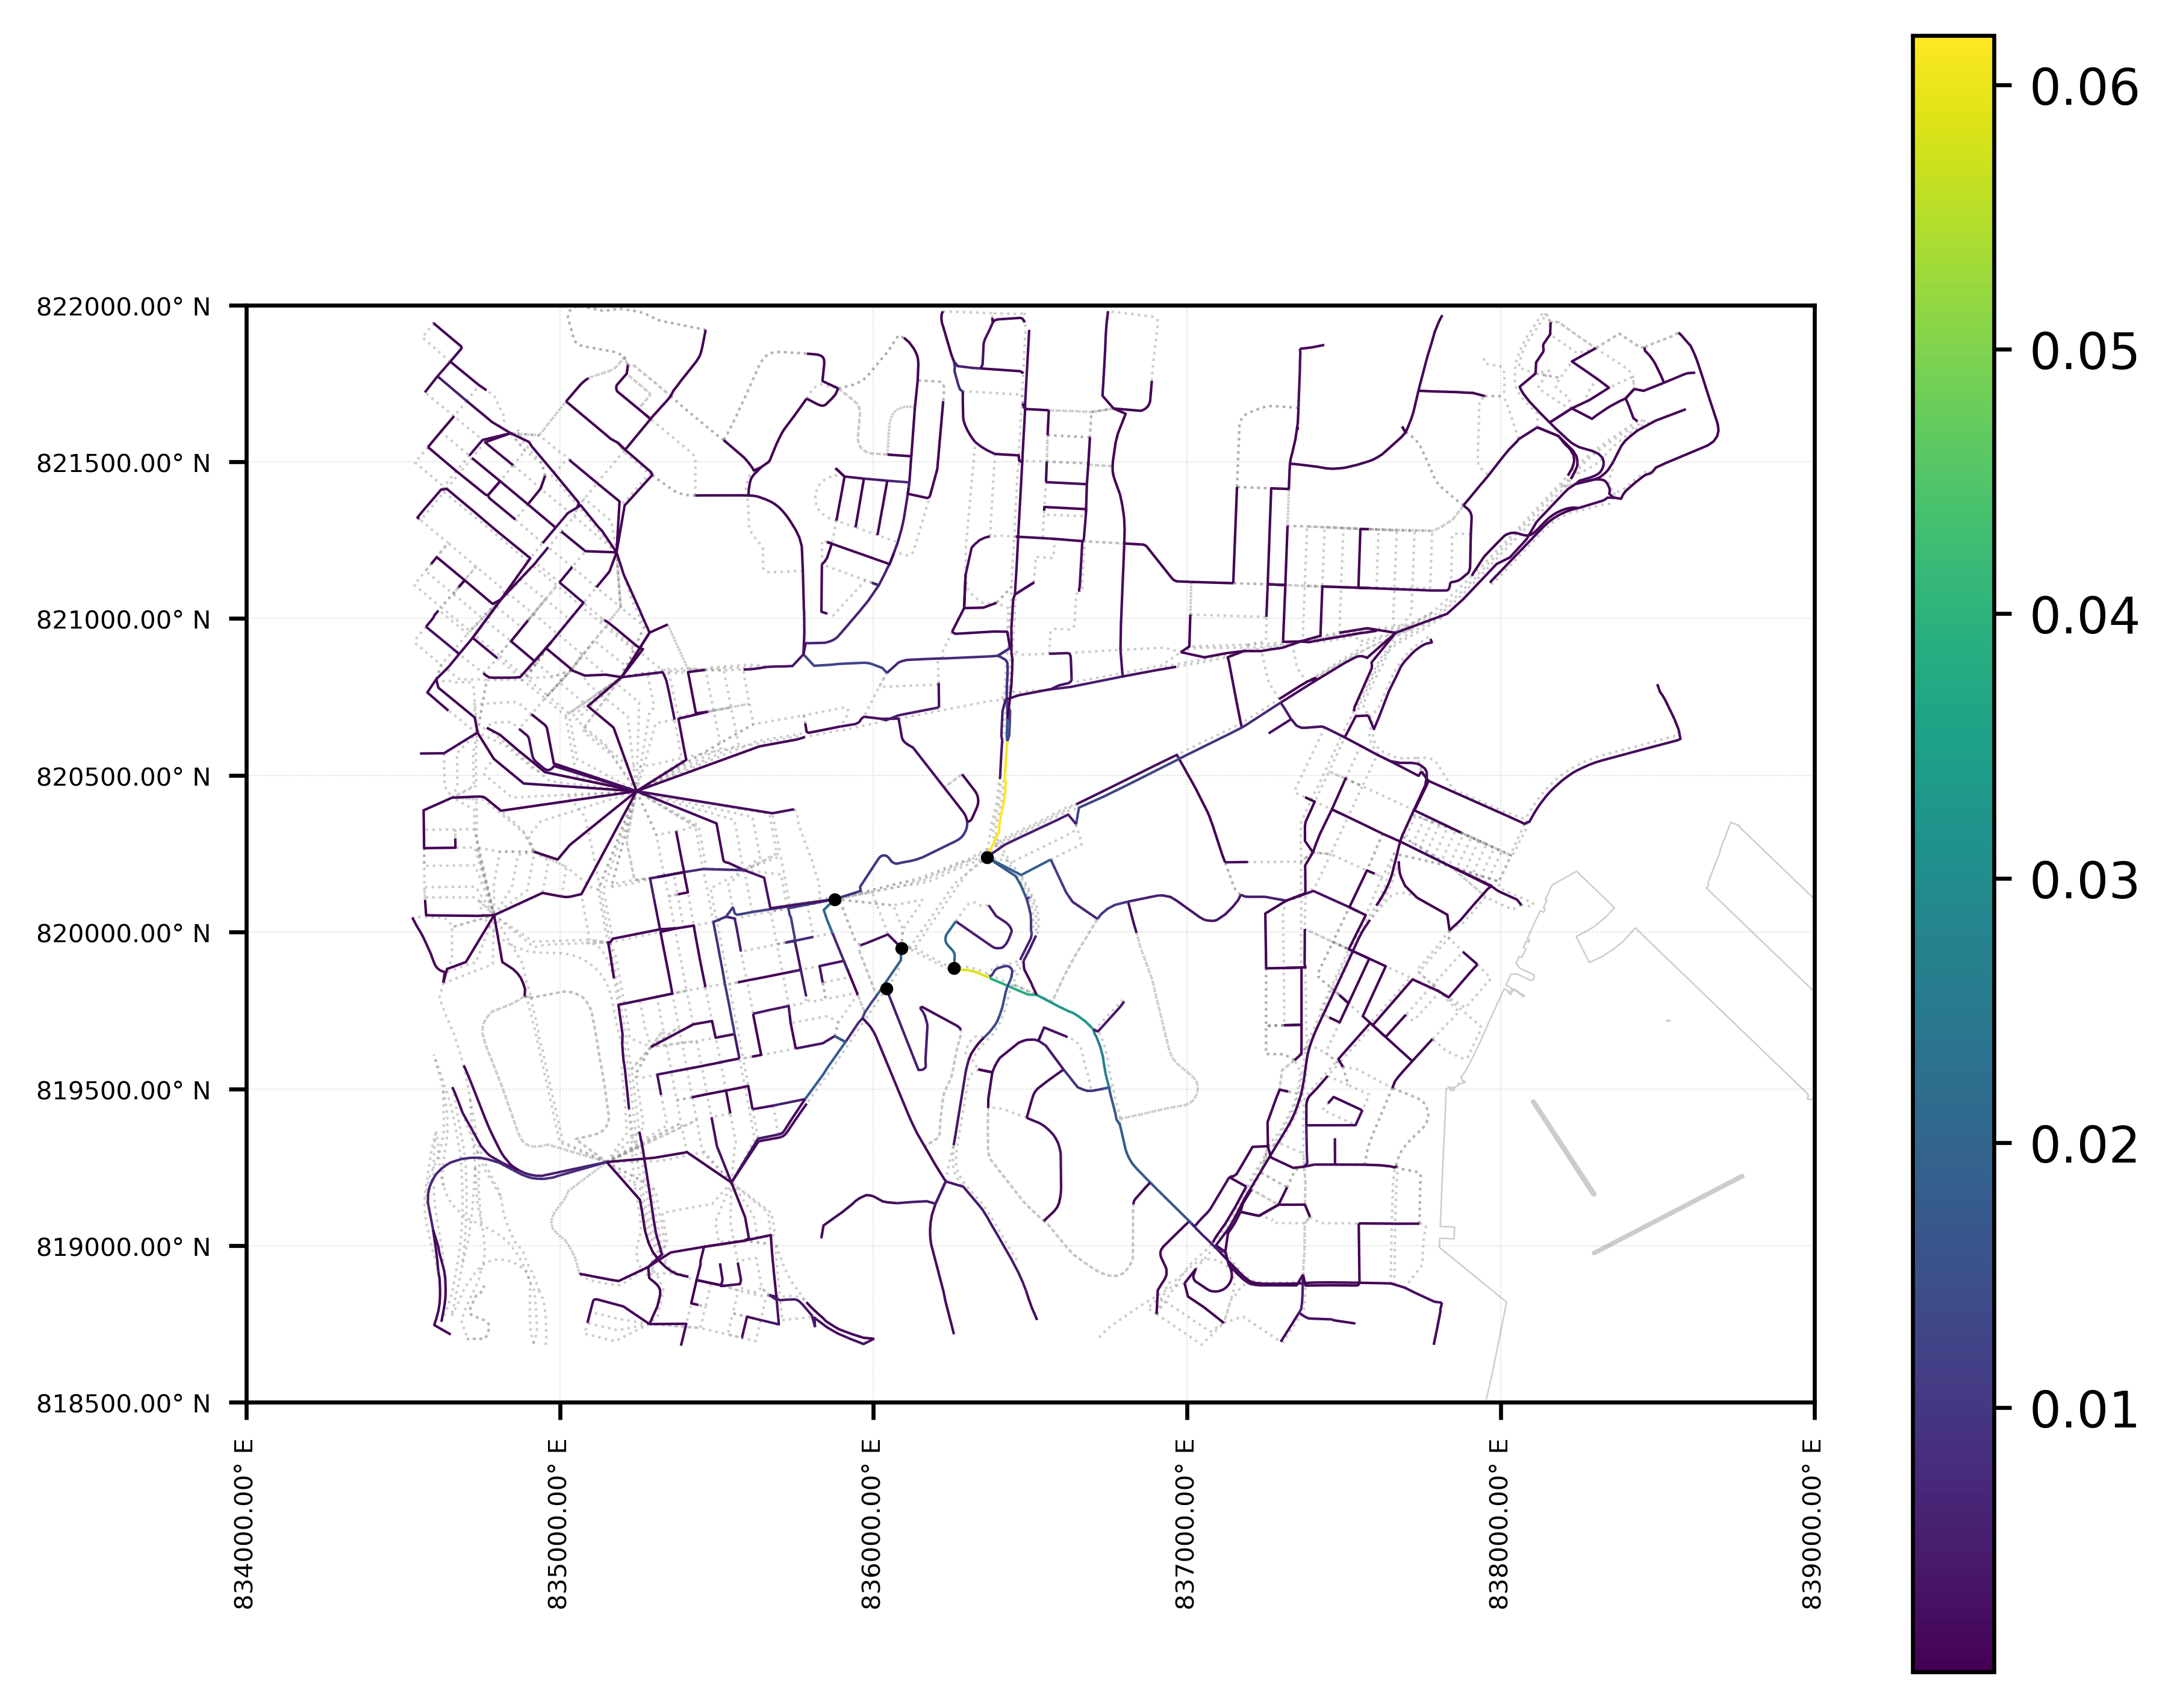

In [31]:
fig = plt.figure(facecolor="w", figsize=(7, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)
edges[edges.delta_efficiency == 0].plot(color="gray", alpha=0.4, ax=ax, lw=0.5, linestyle=":")
edges[edges.delta_efficiency > 0].plot("delta_efficiency", ax=ax, lw=0.5, legend=True, zorder=2)
nodes[nodes.is_infectious == True].plot(ax=ax, color="k", markersize=2.5, zorder=3)
coastline.plot(ax=ax, color="k", zorder=1, alpha=0.2, lw=0.3)

ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° E"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.2f}° N"))
ax.grid()

ax.set_ylim(818500, 822000)
ax.set_xlim(834000, 839000)

plt.savefig("graph_interdiction.pdf")

In [32]:
def cascading_interdiction(G, infectious_subgraph, k=3):
    g = G.copy()
    base_efficiency = network_infectious_efficiency(G, infectious_subgraph)

    interdictions = []

    for i in tqdm.trange(k):
        e, Eff = None, 0
        for edge in tqdm.tqdm(g.es):
            modified_graph = g.copy()
            modified_graph.delete_edges(edge)
            gpeff = network_infectious_efficiency(modified_graph, G.neighborhood(source_node, order=infectious_radius, mode="out"))
            if (base_efficiency - gpeff)/base_efficiency > Eff and gpeff > 0:
                e = edge
                Eff = (base_efficiency - gpeff)/base_efficiency

        print(f"Interdiction #{i + 1}: {e} (∆Eff: {Eff})")
        interdictions.append(e.attributes()["uvk"])
        g.delete_edges(e)

    return interdictions, modified_graph

In [33]:
res, final_graph = cascading_interdiction(i_graph, infectious_nodes, k=4)

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_3724/3599818022.py:2: RuntimeWarning: Couldn't reach some vertices at src/paths/dijkstra.c:441
  return sum(list(map(lambda x: G.es[x]["length"], G.get_shortest_paths(v=source_node, to=destination_node, weights="length", output="epath")[0])))


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1232 [00:00<?, ?it/s]

Interdiction #1: igraph.Edge(<igraph.Graph object at 0x16b8a1030>, 1229, {'uvk': (459, 313, 0), 'length': 277.93602080990576}) (∆Eff: 0.06185766216508682)


  0%|          | 0/1231 [00:00<?, ?it/s]

Interdiction #2: igraph.Edge(<igraph.Graph object at 0x16b8a1030>, 881, {'uvk': (297, 320, 0), 'length': 122.47538991922559}) (∆Eff: 0.12415483182193582)


  0%|          | 0/1230 [00:00<?, ?it/s]

Interdiction #3: igraph.Edge(<igraph.Graph object at 0x16b8a1030>, 932, {'uvk': (319, 320, 0), 'length': 186.6275004781949}) (∆Eff: 0.9793830598719002)


  0%|          | 0/1229 [00:00<?, ?it/s]

Interdiction #4: igraph.Edge(<igraph.Graph object at 0x16b8a1030>, 912, {'uvk': (311, 329, 0), 'length': 349.52786510908805}) (∆Eff: 0.98443437739612)


In [34]:
def nxdnin(G, n, infectious):
    dists = []
    for i in infectious:
        try:
            dist = nx.shortest_path_length(G, n, i, weight="length")
            dists.append(dist)
        except nx.NetworkXNoPath:
            dists.append(np.nan)

    return min(dists)

In [35]:
ngn, nge = nodes, edges.loc[set(edges.index) - set(res)]

/var/folders/1d/97x3559931s0_6hkz64q4zth0000gn/T/ipykernel_3724/584937977.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  ngn, nge = nodes, edges.loc[set(edges.index) - set(res)]


In [36]:
new_graph = osmnx.graph_from_gdfs(ngn, nge)

In [37]:

new_graph = osmnx.graph_from_gdfs(ngn, nge)
infected = final_graph.neighborhood(source_node, order=infectious_radius, mode="out")

ngn.dnin = list(map(lambda x: nxdnin(new_graph, x, infected), list(ngn.index)))

/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting.py:74: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if mpl >= LooseVersion("3.4") or (mpl > LooseVersion("3.3.2") and "+" in mpl):
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/csefalvayk/miniconda3/envs/computational-infectious-disease/lib/python3.10/site-packages/geopandas/plotting

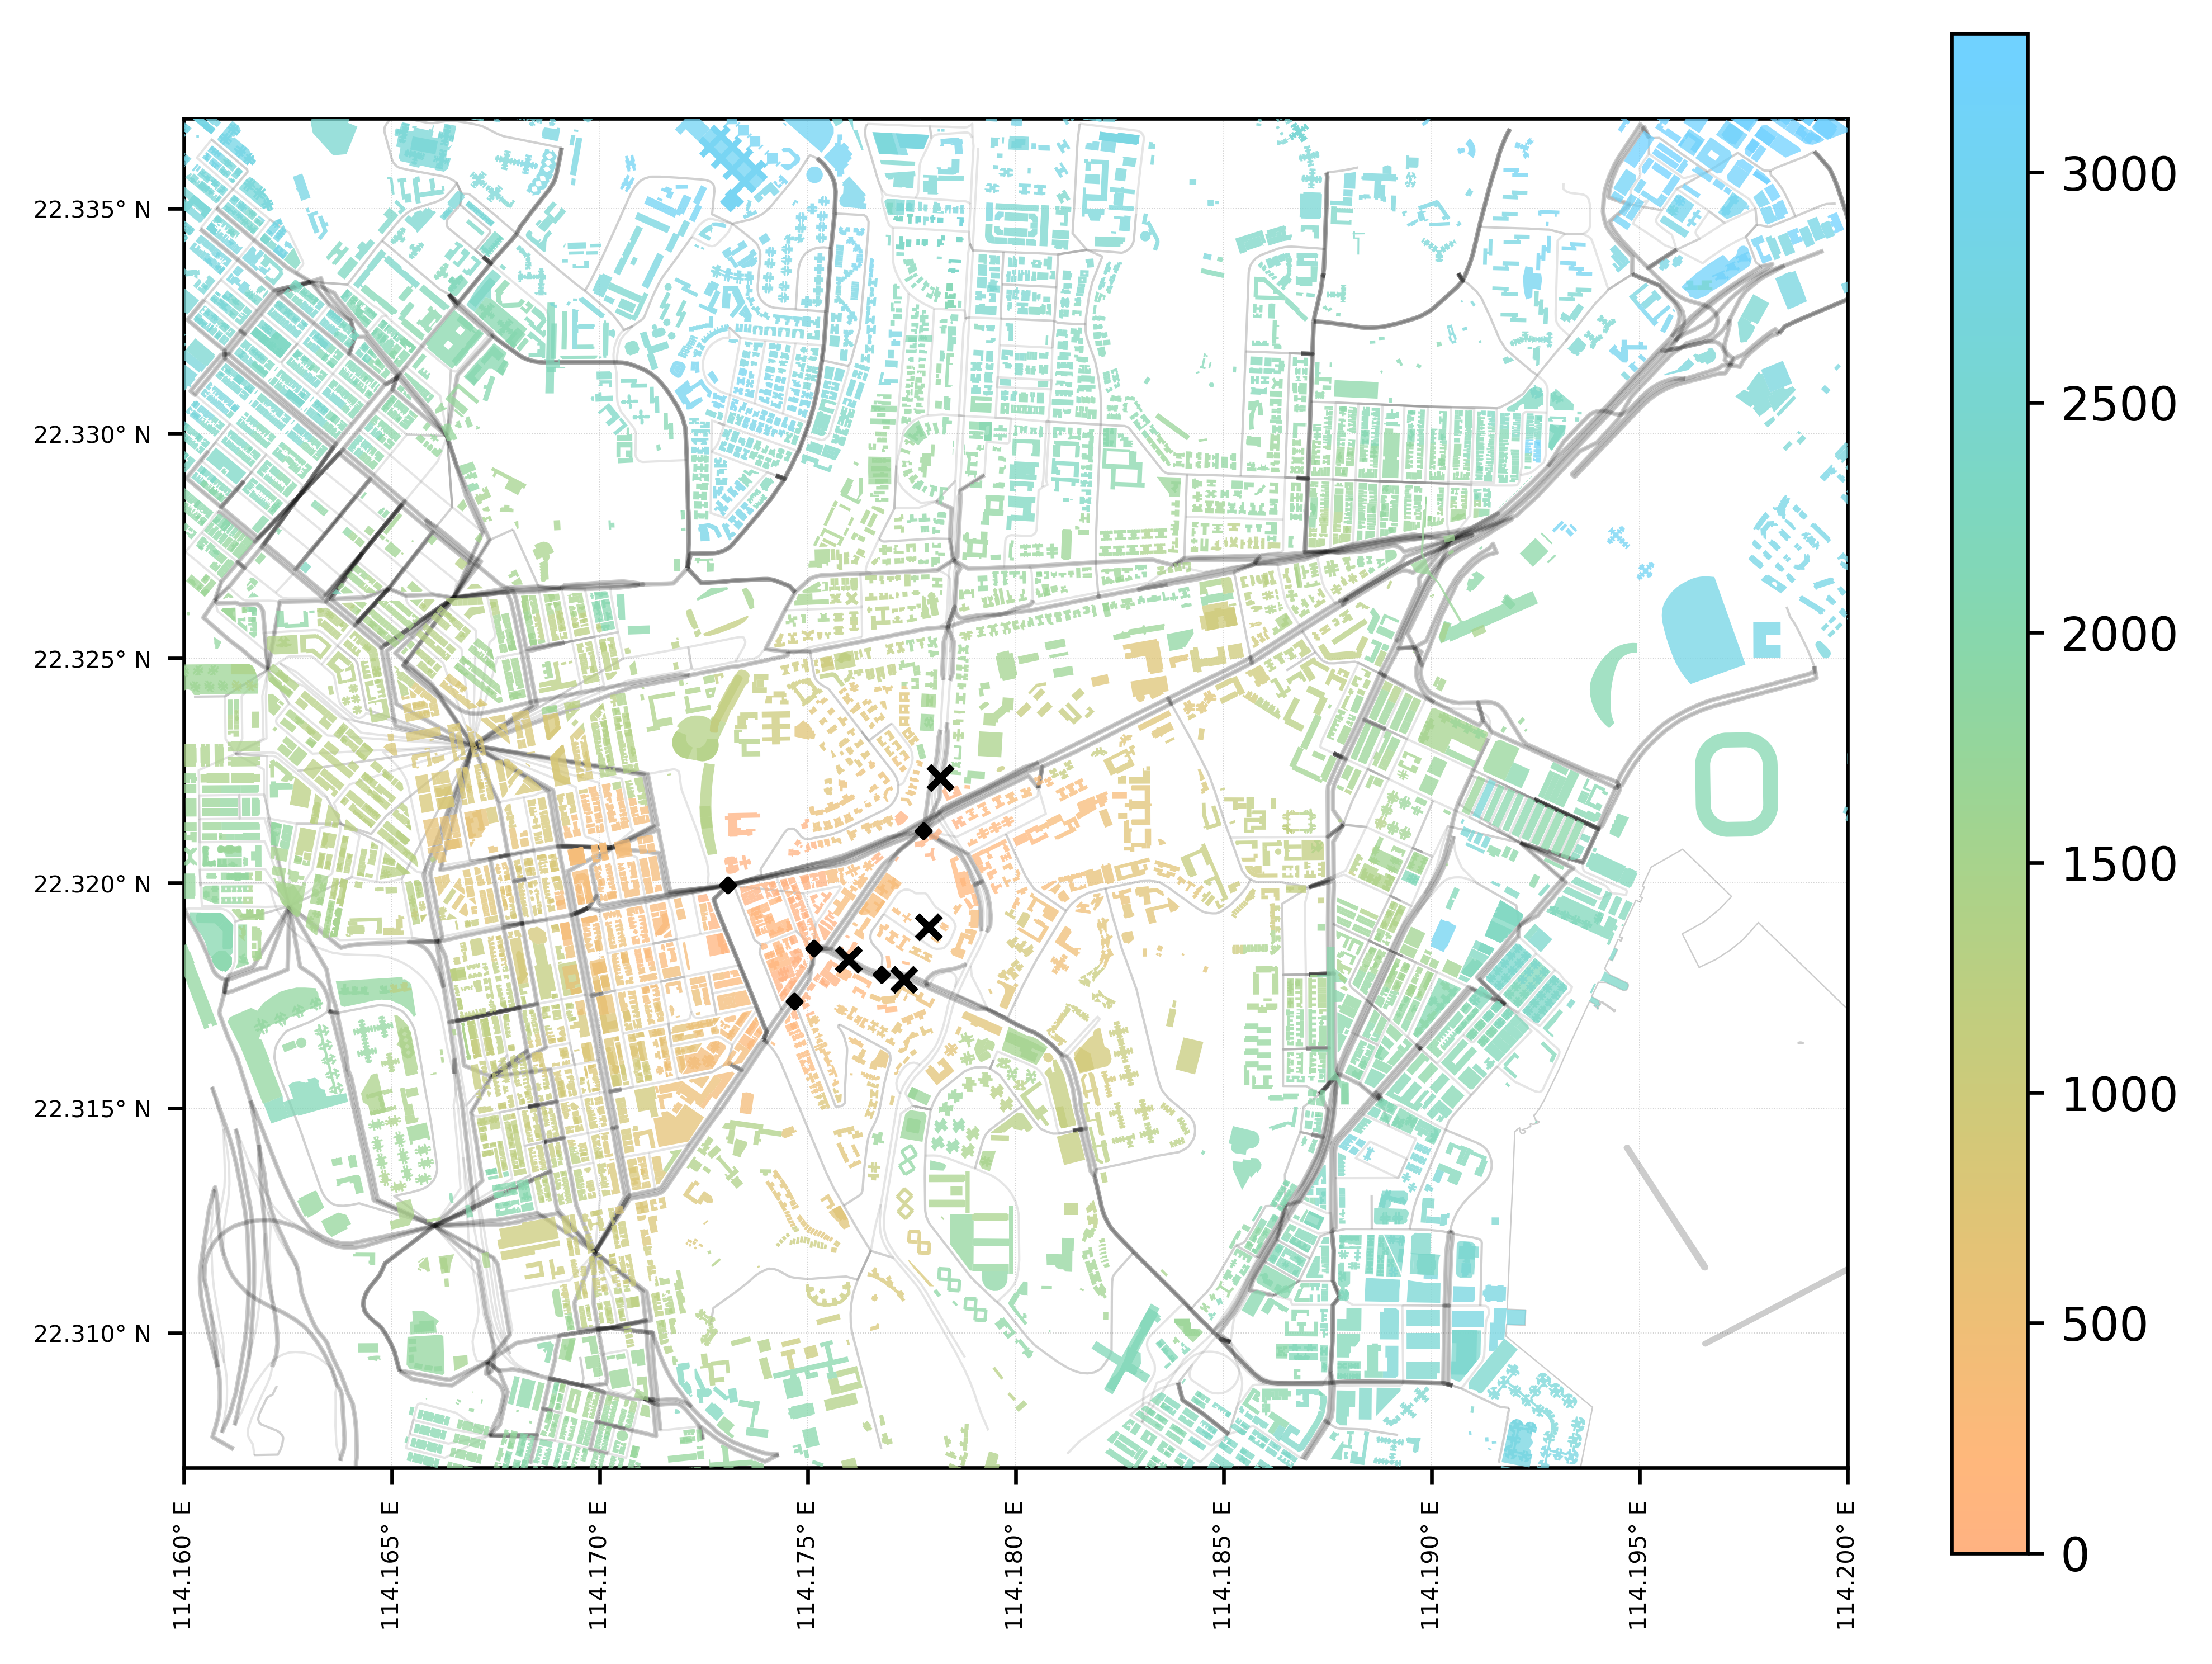

In [38]:
fig = plt.figure(facecolor="w", figsize=(8, 6), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

interdictions = edges.loc[res, :]
interdictions.geometry = interdictions.geometry.to_crs(4326)
interdictions.geometry = interdictions.apply(lambda x: x.geometry.centroid, axis=1)
interdictions.geometry = interdictions.geometry.to_crs(4326)
interdictions.plot(ax=ax, markersize=25, zorder=11, marker="x", c="k")

# ngn[ngn.is_infectious == False].plot("dnin", ax=ax, cmap="inferno_r", markersize=3.25, legend=True, zorder=7)

edges.geometry = edges.geometry.to_crs(4326)
edges.plot(color="gray", ax=ax, lw=0.5, zorder=2, alpha=0.2)
edges[edges.highway.isin(["motorway", "primary", "primary_link", "secondary"])].plot(color="k", ax=ax, lw=1, zorder=3, alpha=0.2)

nodes.geometry = nodes.geometry.to_crs(4326)
nodes[nodes.is_infectious == True].plot(ax=ax, color="k", markersize=4, zorder=13, marker="D", alpha=1)

coastline.geometry = coastline.geometry.to_crs(4326)
coastline.plot(ax=ax, color="k", zorder=1, alpha=0.2, lw=0.3)

footprints = osmnx.geometries_from_bbox(*bbox, tags={"building": True})
footprints.geometry = footprints.geometry.to_crs(2326)
ng_proj = osmnx.project_graph(new_graph, to_crs=2326)
footprints["nearest_node"] = osmnx.nearest_nodes(ng_proj, footprints.geometry.centroid.x, footprints.geometry.centroid.y)
footprints.geometry = footprints.geometry.to_crs(4326)
footprints = footprints.merge(nodes.dnin, left_on="nearest_node", right_index=True)
footprints = footprints[footprints.geom_type != "Point"]
footprints.plot("dnin", ax=ax, cmap=cc.cm.isolum_r, alpha=0.75, legend=True, zorder=9)

ax.tick_params(axis="x", labelsize=5, rotation=90, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.tick_params(axis="y", labelsize=5, grid_alpha=0.2, grid_linewidth=0.2, grid_color="k", grid_linestyle=":")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.3f}° E"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, y: f"{np.abs(x):.3f}° N"))
ax.grid()
ax.set_ylim(bbox[0], bbox[1])
ax.set_xlim(bbox[2], bbox[3])
plt.savefig("graph_interdiction.pdf")